# INSTALLING LIBRARIES

In [ ]:
!pip install transformers scikit-learn datasets torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

# IMPORTING LIBRARIES

In [ ]:
# Google Drive Integration
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data handling and processing libraries
import numpy as np
import pandas as pd
from collections import Counter

# Machine Learning libraries
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    precision_recall_fscore_support, classification_report, roc_curve, auc,
    confusion_matrix
)

# Transformers and NLP model libraries
from transformers import (
    DebertaTokenizer, DebertaForSequenceClassification, Trainer,
    TrainingArguments, EarlyStoppingCallback
)

# Dataset handling for NLP tasks
from datasets import Dataset, DatasetDict

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch and CUDA related libraries
import torch
import torch.cuda
from torch.autograd import profiler
from torchsummary import summary

# System utilities
import os
import psutil
import time
import joblib

# LOADING DATASETS

In [ ]:
manually_labeled_df = pd.read_csv('/content/drive/MyDrive/Dissertation24/Cleaned_Manually_Labelled_Reviews.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Dissertation24/Testing_Reviews.csv')

## SPLITTING DATASET INTO TRAIN AND VALIDATION

In [ ]:
train_df, val_df = train_test_split(manually_labeled_df, test_size=0.2)

## LABEL MAPPING

In [ ]:
# Map string labels to integers
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}

# Apply the mapping to the label columns
train_df['label'] = train_df['label'].map(label_mapping)
val_df['label'] = val_df['label'].map(label_mapping)

# Convert the datatype to integers
train_df['label'] = train_df['label'].astype(int)
val_df['label'] = val_df['label'].astype(int)

# MODEL DEVELOPMENT

## DATA PREPARATION

In [ ]:
# Step 1: Convert DataFrames to Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

## TOKENISATION

In [ ]:
# Step 2: Tokenization - Define and Apply Tokenizer
tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")

# Function to tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["content"], padding="max_length", truncation=True, max_length=128)

# Tokenize the datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Set the format of the tokenized datasets to PyTorch tensors
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_val.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

Map:   0%|          | 0/7281 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Map:   0%|          | 0/9720 [00:00<?, ? examples/s]

## MODEL INITIALIZATION

In [ ]:
# Step 3: Model Initialization - Load Pre-trained Model
model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base", num_labels=3)

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### MEMORY MONITORING BEFORE TRAINING THE MODEL

In [ ]:
# Memory Monitoring - Monitor Memory Usage
def memory_usage():
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss / (1024 ** 2)  # Convert to MB
    print(f"Memory Usage: {mem:.2f} MB")

# Monitor memory usage before training
print("Memory usage before training")
memory_usage()

Memory usage before training
Memory Usage: 1651.56 MB


### DEFINE METRICS CALCULATION

In [ ]:
# Define the metrics that will be used to evaluate the model's performance during and after training
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

## TRAINING CONFIGURATION

In [ ]:
# Step 4: Training Configuration - Define Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.2,
    logging_dir="./logs",
    logging_steps=200,
    metric_for_best_model="accuracy",
    save_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=2e-5,
    warmup_steps=500,
)

# Implement Early Stopping to prevent overfitting
early_stopping = EarlyStoppingCallback(early_stopping_patience=2)

## TRAINING THE DeBERTa MODEL

In [ ]:
# Step 5: Training the Model - Initialize Trainer and Train
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],
)

# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.653900,0.588069,0.764415,0.752371,0.764415,0.755215
2,0.503000,0.483237,0.794069,0.779361,0.794069,0.780733
3,0.375900,0.554624,0.816584,0.822821,0.816584,0.817218
4,0.230600,0.531267,0.845689,0.851349,0.845689,0.847958
5,0.164400,0.586738,0.853926,0.855845,0.853926,0.854778


TrainOutput(global_step=2280, training_loss=0.4126562570270739, metrics={'train_runtime': 1213.3254, 'train_samples_per_second': 30.004, 'train_steps_per_second': 1.879, 'total_flos': 2790442900512000.0, 'train_loss': 0.4126562570270739, 'epoch': 5.0})

### MEMORY MONITORING AFTER TRAINING THE MODEL

In [ ]:
# Monitor memory usage after training
print("Memory usage after training")
memory_usage()

Memory usage after training
Memory Usage: 1722.64 MB


### PLOT TRAINING AND VALIDATION LOSS

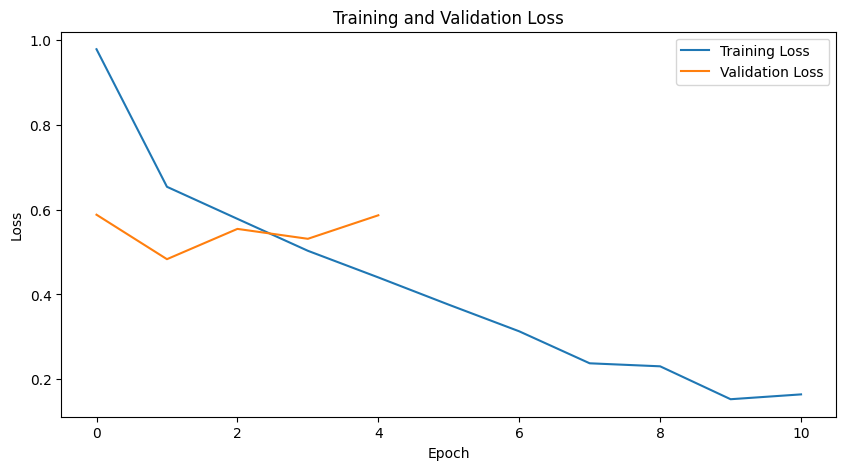

In [ ]:
# Function to plot training and validation loss
def plot_loss(trainer):
    # Extract training and validation loss from trainer's log history
    training_loss = [x['loss'] for x in trainer.state.log_history if 'loss' in x]
    eval_loss = [x['eval_loss'] for x in trainer.state.log_history if 'eval_loss' in x]

    # Plot training and validation loss over epochs
    plt.figure(figsize=(10, 5))
    plt.plot(training_loss, label="Training Loss")
    plt.plot(eval_loss, label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Plot the loss after training
plot_loss(trainer)

## EXTRACT FEATURES FROM DATASET USING THE FINE-TUNED DeBERTa MODEL

In [ ]:
# Step 6: Function to extract features from the dataset using the model
def extract_features(dataset, batch_size=16):
    # Set the device (GPU if available, otherwise CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    all_features = []

    # Process the dataset in batches
    for i in range(0, len(dataset), batch_size):
        # Extract input IDs and attention mask for the current batch
        inputs = dataset["input_ids"][i:i+batch_size].to(device)
        attention_mask = dataset["attention_mask"][i:i+batch_size].to(device)

        # Perform inference with mixed precision for efficiency
        with torch.no_grad():
            with torch.cuda.amp.autocast():
                outputs = model.deberta(inputs, attention_mask=attention_mask)

        # Extract and store the features from the model's output
        features = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_features.append(features)

    # Concatenate all features and return as a single array
    return np.concatenate(all_features, axis=0)

# Extract features for training, validation, and testing datasets
train_features = extract_features(tokenized_train, batch_size=16)
val_features = extract_features(tokenized_val, batch_size=16)
test_features = extract_features(tokenized_test)

## TRAINING THE RANDOM FOREST CLASSIFIER MODEL

In [ ]:
# Step 7: Train a RandomForest model using the extracted features
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_features, train_df["label"])

RandomForestClassifier(random_state=42)

## MAKE PREDICTIONS ON THE VALIDATION SET

In [ ]:
# Step 8: Make predictions on the validation set
val_predictions = rf_model.predict(val_features)

# MODEL EVALUATION

## CLASSIFICATION REPORT

In [ ]:
# Display Classification Report
print("Classification Report:")
print(classification_report(val_df["label"], val_predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       832
           1       0.70      0.73      0.71       397
           2       0.92      0.88      0.90       592

    accuracy                           0.86      1821
   macro avg       0.84      0.84      0.84      1821
weighted avg       0.86      0.86      0.86      1821



## ACCURACY, PRECISION, RECALL, AND F1-SCORE

In [ ]:
# Calculate and Display Accuracy, Precision, Recall, and F1-Score
accuracy = accuracy_score(val_df["label"], val_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(val_df["label"], val_predictions, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8599670510708401
Precision: 0.8625509297870153
Recall: 0.8599670510708401
F1 Score: 0.8610048660036601


## MICRO AND MACRO AVERAGES

In [ ]:
# Calculate Micro and Macro Averages for Precision, Recall, and F1-Score
precision_micro = precision_score(val_df["label"], val_predictions, average='micro')
recall_micro = recall_score(val_df["label"], val_predictions, average='micro')
f1_micro = f1_score(val_df["label"], val_predictions, average='micro')

precision_macro = precision_score(val_df["label"], val_predictions, average='macro')
recall_macro = recall_score(val_df["label"], val_predictions, average='macro')
f1_macro = f1_score(val_df["label"], val_predictions, average='macro')

print(f"Micro Precision: {precision_micro}, Micro Recall: {recall_micro}, Micro F1: {f1_micro}")
print(f"Macro Precision: {precision_macro}, Macro Recall: {recall_macro}, Macro F1: {f1_macro}")

Micro Precision: 0.8599670510708401, Micro Recall: 0.8599670510708401, Micro F1: 0.8599670510708401
Macro Precision: 0.8387863953324967, Macro Recall: 0.8394468388171159, Macro F1: 0.8388050606895984


## CONFUSION MATRIX

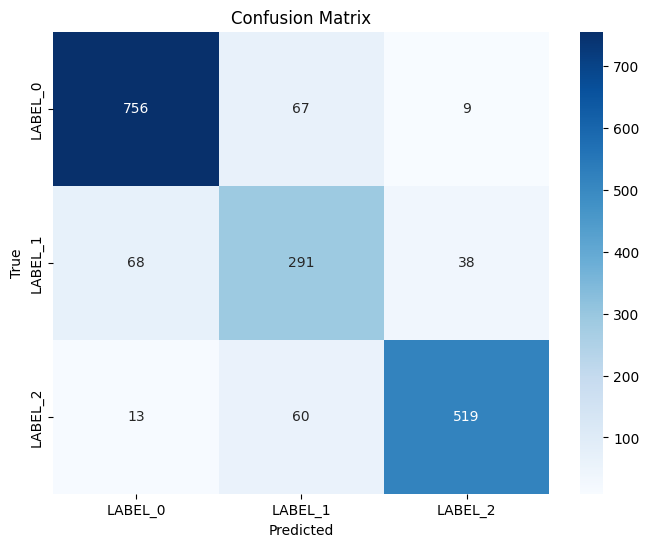

In [ ]:
# Plot Confusion Matrix
conf_matrix = confusion_matrix(val_df["label"], val_predictions)

# Configure the plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.config.id2label.values(),
            yticklabels=model.config.id2label.values())

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()

## ROC AUC SCORE

In [ ]:
# Calculate ROC AUC Score for Multi-Class Classification
roc_auc = roc_auc_score(val_df["label"], rf_model.predict_proba(val_features), multi_class='ovr')

print(f"\nROC AUC: {roc_auc}\n")


ROC AUC: 0.9399206797103367



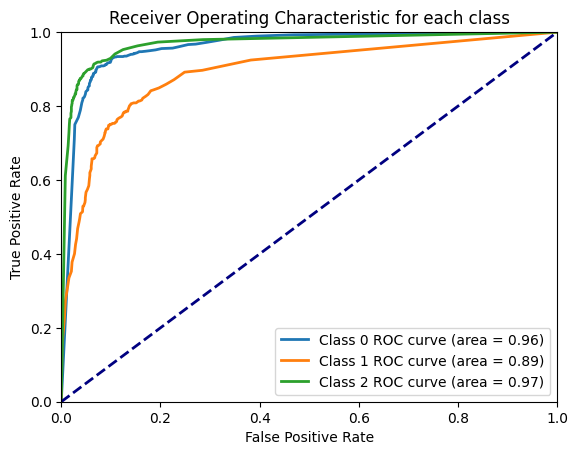

In [ ]:
# Determine the number of classes
n_classes = len(set(val_df["label"]))

# Binarize the output labels for ROC curve calculation
y_test = label_binarize(val_df["label"], classes=[*range(n_classes)])
y_score = rf_model.predict_proba(val_features)

plt.figure()

# Plot ROC curve for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} ROC curve (area = {roc_auc:.2f})')

# Plot the reference line for random chance
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")

plt.show()


# MODEL PREDICTION

In [ ]:
test_predictions = rf_model.predict(test_features)
test_predictions

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
# Function to plot a pie chart of the mapped predictions
def plot_mapped_predictions_pie_chart_manual(test_predictions):
    # Map numerical predictions to sentiment labels
    label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
    mapped_predictions = [label_mapping[label] for label in test_predictions]

    # Count the occurrences of each label
    mapped_prediction_counts = Counter(mapped_predictions)

    # Extract labels and their corresponding counts
    labels, counts = zip(*mapped_prediction_counts.items())

    plt.figure(figsize=(8, 6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Distribution of Mapped Predictions')
    plt.show()

# Function to create and display a summary table of the mapped predictions
def create_summary_table_manual(test_predictions):
    # Map numerical predictions to sentiment labels
    label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
    mapped_predictions = [label_mapping[label] for label in test_predictions]

    # Count the occurrences of each label
    mapped_prediction_counts = Counter(mapped_predictions)

    # Calculate the total number of predictions
    total_mapped_predictions = len(mapped_predictions)

    # Create a DataFrame summarising the counts and percentages of each label
    mapped_prediction_summary = pd.DataFrame.from_dict(mapped_prediction_counts, orient='index', columns=['Count'])
    mapped_prediction_summary['Percentage'] = (mapped_prediction_summary['Count'] / total_mapped_predictions) * 100

    print("\nSummary Table of Distribution of Mapped Predictions:\n")

    return mapped_prediction_summary

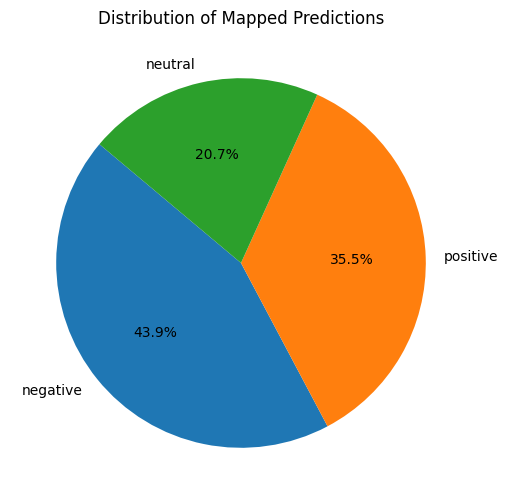


Summary Table of Distribution of Mapped Predictions:



,Count,Percentage
negative,4264,43.868313
positive,3448,35.473251
neutral,2008,20.658436


In [ ]:
# Plot the pie chart of mapped predictions
plot_mapped_predictions_pie_chart_manual(test_predictions)

# Create and display the summary table of mapped predictions
create_summary_table_manual(test_predictions)

# MODEL ANALYSIS

In [ ]:
# Final Analysis Section

print("\n========== Final Analysis Section ==========")

print("\n========== Model Complexity Analysis ==========")
# Analyze Model Complexity (Number of Parameters)
def analyze_model_complexity(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Parameters: {total_params}")
    print(f"Trainable Parameters: {trainable_params}")
analyze_model_complexity(model)

print("\n========== Memory Usage Analysis ==========")
# Memory usage function
def memory_usage():
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss / (1024 ** 2)
    print(f"Memory Usage: {mem:.2f} MB")
print("Memory usage after training and predictions:")
memory_usage()

print("\n========== Inference Time Analysis ==========")
# Inference time measurement
start_time = time.time()
val_predictions = rf_model.predict(val_features)
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference Time for Validation Set: {inference_time:.2f} seconds")

print("\n========== Model Saving and Loading Time Analysis ==========")
# Model saving and loading time analysis
start_time = time.time()
joblib.dump(rf_model, 'rf_model.pkl')
end_time = time.time()
print(f"Model saving time: {end_time - start_time:.2f} seconds")
start_time = time.time()
loaded_model = joblib.load('rf_model.pkl')
end_time = time.time()
print(f"Model loading time: {end_time - start_time:.2f} seconds")

print("\n========== Final Analysis Complete ==========")


========== Final Analysis Section ==========

========== Model Complexity Analysis ==========
Total Parameters: 139194627
Trainable Parameters: 139194627

========== Memory Usage Analysis ==========
Memory usage after training and predictions:
Memory Usage: 1891.26 MB

========== Inference Time Analysis ==========
Inference Time for Validation Set: 0.05 seconds

========== Model Saving and Loading Time Analysis ==========
Model saving time: 0.04 seconds
Model loading time: 0.03 seconds

========== Final Analysis Complete ==========


# SAVING THE PREDICTIONS

In [ ]:
test_df_copy = test_df.copy()
test_df_copy['label'] = test_predictions
test_df_copy.to_csv('/content/drive/MyDrive/Dissertation24/Hybrid_ManualPredictions.csv', index=False)

print("Predictions have been saved to Hybrid_ManualPredictions.csv")

Predictions have been saved to Hybrid_ManualPredictions.csv
